# Physics-informed microphysics neural network emulator

David John Gagne

The goal of this approach is to include more physical constraints and make the training easier for the microphysics emulator. 

The physics-informed neural network setup integrates the following components.

1. Predict the updated microphysical terms rather than tendencies. The tendencies have very weird distributions that are hard for one neural network to fit. The original values on the other hand are all greater than 0, so it is easier to ensure that outputs are always greater than 0 this way.
$y_{new} = y_{old} + y_{tend} dt$

$dt=1800 \text{ s}$

2. Keep all inputs and outputs in log space for training ideally.

3. Enforce mass conservation between cloud and rain. 
$ q_{ro} + q_{co} = q_{rn} + q_{cn}$

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from os.path import join
import xarray as xr
import dask.dataframe as dd
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import tensorflow as tf
from mlmicrophysics.models import DenseNeuralNetwork
from sklearn.inspection import partial_dependence
from scipy.special import gamma
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
from sklearn.model_selection import GroupShuffleSplit
%matplotlib inline

2022-11-21 13:53:01.518174: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
def logit(p):
    p2 = np.minimum(np.maximum(p.astype(np.float64), 1e-5), 0.9999999999)
    return np.log(p2) - np.log(1 - p2)

In [ ]:
mp_path = "/glade/p/cisl/aiml/dgagne/cam_mp_files_run6_lim10ppm_parquet/"
mp_files = sorted(glob(join(mp_path, "*.parquet")))

In [ ]:
mp_data = pd.concat([pd.read_parquet(mp_files[x]) for x in range(0, len(mp_files), 10)], ignore_index=True)
#mp_data.loc[:, "precip_frac_logit"] = logit(mp_data["precip_frac"].values)
#mp_data.loc[:, "lcldm_logit"] = logit(mp_data["lcldm"].values)

In [ ]:
mp_data.columns

In [6]:
mp_data.loc[:, "Q_mass_in"] = mp_data[["QC_TAU_in_v2", "QR_TAU_in_v2"]].sum(axis=1)
mp_data.loc[:, "Q_mass_out"] = mp_data[["QC_TAU_out_v2", "QR_TAU_out_v2"]].sum(axis=1)
mp_data.loc[:, "Q_mass_diff"] = mp_data.loc[:, "Q_mass_out"] - mp_data.loc[:, "Q_mass_in"]

In [23]:
def test_adding_fake_col(data):
    data.loc[:, "fake"] = np.random.random(data.shape[0])

In [24]:
test_adding_fake_col(mp_data)

In [25]:
mp_data

,lat,lev,lon,P0,PS,depth,row,col,hyam,hybm,...,nrtend_TAU_v2,qctend_MG2_v2,nctend_MG2_v2,qrtend_MG2_v2,nrtend_MG2_v2,time,Q_mass_in,Q_mass_out,Q_mass_diff,fake
0,-89.057592,887.020249,176.25,100000.0,66423.453125,26,1,141,0.022209,0.864811,...,0.000000,-3.544266e-16,-0.000434,3.544266e-16,0.000123,0.000000,5.253537e-08,5.253537e-08,0.0,0.252305
1,-89.057592,887.020249,177.50,100000.0,66438.882812,26,1,142,0.022209,0.864811,...,0.000000,-1.971529e-16,-0.003775,1.971529e-16,0.000014,0.000000,2.512119e-07,2.512119e-07,0.0,0.713664
2,-89.057592,887.020249,178.75,100000.0,66455.273438,26,1,143,0.022209,0.864811,...,0.000000,-8.916741e-16,-0.008336,8.916741e-16,0.000037,0.000000,4.430063e-07,4.430063e-07,0.0,0.250373
3,-89.057592,887.020249,180.00,100000.0,66471.234375,26,1,144,0.022209,0.864811,...,0.000000,-6.341101e-16,-0.012627,6.341101e-16,0.000018,0.000000,6.519699e-07,6.519699e-07,0.0,0.604972
4,-89.057592,887.020249,181.25,100000.0,66488.093750,26,1,145,0.022209,0.864811,...,0.000000,-1.064722e-15,-0.018099,1.064722e-15,0.000023,0.000000,8.549007e-07,8.549007e-07,0.0,0.141560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11837566,88.115183,992.556095,353.75,100000.0,100300.039062,31,189,283,0.000000,0.992556,...,0.001200,-2.498786e-12,-2.890809,2.498786e-12,0.037400,421.666667,4.409971e-05,4.409971e-05,0.0,0.744272
11837567,88.115183,992.556095,355.00,100000.0,100305.179688,31,189,284,0.000000,0.992556,...,0.378634,-2.625028e-12,-2.968276,2.625028e-12,0.040107,421.666667,4.556400e-05,4.556400e-05,0.0,0.471084
11837568,88.115183,992.556095,356.25,100000.0,100310.765625,31,189,285,0.000000,0.992556,...,0.465071,-2.901192e-12,-3.168408,2.901192e-12,0.044327,421.666667,4.766818e-05,4.766818e-05,0.0,0.558066
11837569,88.115183,992.556095,357.50,100000.0,100316.789062,31,189,286,0.000000,0.992556,...,0.002152,-3.147012e-12,-3.320143,3.147012e-12,0.048082,421.666667,4.920372e-05,4.920372e-05,0.0,0.777053


In [31]:
idx_1 = ((mp_data["Q_mass_diff"] == 0) & 
                           (mp_data["NC_TAU_out_v2"] > 0) & 
                           (mp_data["NR_TAU_out_v2"] > 0) &
                           (mp_data["QC_TAU_out_v2"] > 0) &
                           (mp_data["QR_TAU_out_v2"] > 0) & 
                           (mp_data["QC_TAU_in_v2"] >= 1e-6))
idx_2 = ((mp_data["Q_mass_diff"] == 0) & (mp_data["QC_TAU_out_v2"] > 0) & 
         (mp_data["NC_TAU_out_v2"] > 0) & 
                           (mp_data["NR_TAU_out_v2"] > 0) & (mp_data["QR_TAU_out_v2"] > 0) & (mp_data["QC_TAU_in_v2"] >= 1e-6))
print(np.count_nonzero(idx_1))
print(np.count_nonzero(idx_2))

4980702
4980702


In [7]:
mp_good_data = mp_data.loc[(mp_data["Q_mass_diff"] == 0) & 
                           (mp_data["NC_TAU_out_v2"] > 0) & 
                           (mp_data["NR_TAU_out_v2"] > 0) &
                           (mp_data["QC_TAU_out_v2"] > 0) &
                           (mp_data["QR_TAU_out_v2"] > 0) & 
                           (mp_data["QC_TAU_in_v2"] >= 1e-6)].reset_index()

In [9]:
input_cols = ["QC_TAU_in_v2", "QR_TAU_in_v2", "NC_TAU_in_v2", "NR_TAU_in_v2", 'RHO_CLUBB_lev', "precip_frac", "lcldm"]
output_cols = ["QC_TAU_out_v2", "QR_TAU_out_v2", "NC_TAU_out_v2", "NR_TAU_out_v2"]
gss = GroupShuffleSplit(n_splits=1, train_size=0.7)
train_idxs, test_idxs = next(gss.split(mp_good_data[input_cols], mp_good_data[output_cols], mp_good_data["time"]))

In [14]:
train_x = mp_good_data.loc[train_idxs, input_cols]
train_y = mp_good_data.loc[train_idxs, output_cols]
val_x = mp_good_data.loc[test_idxs, input_cols]
val_y = mp_good_data.loc[test_idxs, output_cols]
in_scaler = QuantileTransformer(n_quantiles=100)
out_scaler = QuantileTransformer(n_quantiles=100)
train_x_s = in_scaler.fit_transform(train_x)
train_y_s = out_scaler.fit_transform(train_y)
val_x_s = in_scaler.transform(val_x)
val_y_s = out_scaler.transform(val_y)

In [20]:
dir(in_scaler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_inputs',
 '_check_n_features',
 '_dense_fit',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse_fit',
 '_transform',
 '_transform_col',
 '_validate_data',
 'copy',
 'fit',
 'fit_transform',
 'get_params',
 'ignore_implicit_zeros',
 'inverse_transform',
 'n_features_in_',
 'n_quantiles',
 'n_quantiles_',
 'output_distribution',
 'quantiles_',
 'random_state',
 'references_',
 'set_params',
 'subsample',
 'transform']

In [22]:
in_scaler.references_

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

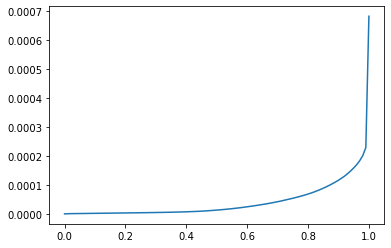

In [15]:
plt.plot(in_scaler.references_, in_scaler.quantiles_[:, 0])

In [ ]:
plt.plot(in_scaler.quantiles_[:, 0], in_scaler.references_)

In [ ]:
dnn = DenseNeuralNetwork(hidden_layers=3, hidden_neurons=256, activation="gelu", l2_weight=0, verbose=1, 
                         batch_size=1024, epochs=50, lr=0.0001)
losses = dnn.fit(train_x_s, train_y_s, xv=val_x_s, yv=val_y_s)

In [ ]:
dnn_preds = dnn.model.predict(val_x_s, batch_size=36000)

In [ ]:
y_pred_val = out_scaler.inverse_transform(dnn_preds)

In [ ]:
pred_mass = y_pred_val[:, 0] + y_pred_val[:, 1]

In [ ]:
plt.hist(mp_good_data.loc[test_idxs]["Q_mass_in"] - pred_mass, bins=100)
plt.gca().set_yscale("log")

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist(np.log10(y_pred_val[:, i]), np.arange(-20, 10, 0.5), label="Emulator")
    plt.hist(np.log10(val_y.values[:, i]), np.arange(-20, 10, 0.5), histtype="step", label="TAU")
    plt.gca().set_yscale("log")
    plt.xlabel(input_cols[i].split("_")[0])
    plt.ylabel("Frequency")
    plt.legend()
plt.savefig("mp_nn_hist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
plt.figure(figsize=(11, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(np.log10(y_pred_val[:, i]), np.log10(val_y.values[:, i]), 
                bins=100, cmin=1, norm=LogNorm())
    plt.title(input_cols[i].split("_")[0])
    plt.colorbar(label="Frequency")
    if i > 1:
        plt.xlabel("Emulator")
    if i % 2 == 0:
        plt.ylabel("Output")
plt.savefig("mp_nn_2dhist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
out_tend_cols = ["qctend_TAU_v2", "qrtend_TAU_v2", "nctend_TAU_v2", "nrtend_TAU_v2"]
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    if i % 2 == 0:
        plt.hist2d(np.log10(np.maximum(val_x.iloc[:, i], 1e-25)), 
                   np.log10(np.maximum(-mp_good_data.loc[test_idxs, out_tend_cols[i]], 1e-30)), 
                        bins=100, cmin=1, norm=LogNorm())
    elif i == 1:
        plt.hist2d(np.log10(np.maximum(val_x.iloc[:, i], 1e-25)), 
                   np.log10(np.maximum(mp_good_data.loc[test_idxs, out_tend_cols[i]], 1e-18)), 
                        bins=100, cmin=1, norm=LogNorm())
    elif i == 3:
        plt.hist2d(np.log10(np.maximum(val_x.iloc[:, i], 1e-25)), mp_good_data.loc[test_idxs, out_tend_cols[i]], 
                        bins=100, cmin=1, norm=LogNorm())
    plt.title(input_cols[i])
    if i > 1:
        plt.xlabel("Input")
    if i % 2 == 0:
        plt.ylabel("Output Tendency")
plt.savefig("mp_nn_tend_2dhist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
out_tend_cols = ["qctend_TAU_v2", "qrtend_TAU_v2", "nctend_TAU_v2", "nrtend_TAU_v2"]
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    if i % 2 == 0:
        plt.hist2d(np.log10(np.maximum(val_x.iloc[:, 0], 1e-25)), 
                   np.log10(np.maximum(-mp_good_data.loc[test_idxs, out_tend_cols[i]], 1e-30)), 
                        bins=100, cmin=1, norm=LogNorm())
    elif i == 1:
        plt.hist2d(np.log10(np.maximum(val_x.iloc[:, 0], 1e-25)), 
                   np.log10(np.maximum(mp_good_data.loc[test_idxs, out_tend_cols[i]], 1e-18)), 
                        bins=100, cmin=1, norm=LogNorm())
    elif i == 3:
        plt.hist2d(np.log10(np.maximum(val_x.iloc[:, 0], 1e-25)), mp_good_data.loc[test_idxs, out_tend_cols[i]], 
                        bins=100, cmin=1, norm=LogNorm())
    plt.title(input_cols[i])
    if i > 1:
        plt.xlabel("QC Input")
    if i % 2 == 0:
        plt.ylabel("Output Tendency")
plt.savefig("mp_nn_qc_tend_2dhist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(np.log10(np.maximum(val_x.iloc[:, i], 1e-25)), np.log10(val_y.values[:, i]), 
                bins=100, cmin=1, norm=LogNorm())
    plt.title(input_cols[i])
    if i > 1:
        plt.xlabel("Input")
    if i % 2 == 0:
        plt.ylabel("Output")
plt.savefig("mp_tau_out_2dhist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(np.log10(np.maximum(val_x.iloc[:, 0], 1e-25)), np.log10(val_y.values[:, i]), 
                bins=100, cmin=1, norm=LogNorm())
    plt.title(input_cols[i])
    if i > 1:
        plt.xlabel("QC Input")
    if i % 2 == 0:
        plt.ylabel("Output")
plt.savefig("mp_tau_qc_out_2dhist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(np.log10(val_y.values[:, 0]), np.log10(val_y.values[:, i]), 
                bins=100, cmin=1, norm=LogNorm())
    plt.title(input_cols[i])
    if i > 1:
        plt.xlabel("QC Input")
    if i % 2 == 0:
        plt.ylabel("Output")
plt.savefig("mp_tau_qc_out_all_out_2dhist.png", dpi=300, bbox_inches="tight", facecolor="w")

In [ ]:
val_x

In [ ]:
train_y.max()

In [ ]:
qc_bins = np.arange(-18, -2)
qr_bins = np.arange(-25, -2)
mass_flag = mp_data["Q_mass_out"] != mp_data["Q_mass_in"]
h_all = np.histogram2d(np.log10(mp_data["QC_TAU_in_v2"]), 
                       np.log10(mp_data["QR_TAU_in_v2"]), 
                       bins=(qc_bins, qr_bins))
h_neg = np.histogram2d(np.log10(mp_data.loc[mass_flag, "QC_TAU_in_v2"]), 
                       np.log10(mp_data.loc[mass_flag, "QR_TAU_in_v2"]),
                      bins=(qc_bins, qr_bins))
bad_mass_prob = h_neg[0] / h_all[0]
bad_mass_prob = np.ma.array(bad_mass_prob, mask=bad_mass_prob<=0)
plt.pcolormesh(qc_bins[:-1], qr_bins[:-1], bad_mass_prob.T)
plt.colorbar()
plt.xlabel("QC in")
plt.ylabel("QR in")
plt.title("Probability of Mass Conservation Breaking")
plt.savefig("mass_cons_break.png", dpi=200, bbox_inches="tight")

In [ ]:
print(np.abs(mp_data["qctend_MG2_v2"] + mp_data["qrtend_MG2_v2"]).max())
print(np.abs(mp_data["qctend_TAU_v2"] + mp_data["qrtend_TAU_v2"]).max())

In [ ]:
print(np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]).max())

In [ ]:
np.count_nonzero(np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"])) / mp_data.shape[0]

In [ ]:
plt.hist(mp_data["Q_mass_in"] - mp_data["Q_mass_out"], bins=20)
plt.gca().set_yscale("log")
plt.xlabel("Q mass in - Q mass out")
plt.ylabel("Frequency")
plt.savefig("qmdiff.png", dpi=200, bbox_inches="tight")

In [ ]:
qc_bins = np.arange(-18, -2)
qr_bins = np.arange(-25, -2)
mass_flag = mp_data["QR_TAU_out_v2"] < 0
h_all = np.histogram2d(np.log10(mp_data["QC_TAU_in_v2"]), 
                       np.log10(mp_data["QR_TAU_in_v2"]), 
                       bins=(qc_bins, qr_bins))
h_neg = np.histogram2d(np.log10(mp_data.loc[mass_flag, "QC_TAU_in_v2"]), 
                       np.log10(mp_data.loc[mass_flag, "QR_TAU_in_v2"]),
                      bins=(qc_bins, qr_bins))
bad_mass_prob = h_neg[0] / h_all[0]
bad_mass_prob = np.ma.array(bad_mass_prob, mask=bad_mass_prob<=0)
plt.pcolormesh(qc_bins[:-1], qr_bins[:-1], bad_mass_prob.T)
plt.colorbar()
plt.xlabel("QC in")
plt.ylabel("QR in")
plt.title("Probability of Negative QR Out")
plt.savefig("prob_neg_qr.png", dpi=200, bbox_inches="tight")

In [ ]:
qc_bins = np.arange(-18, -2)
qr_bins = np.arange(-25, -2)
mass_flag = mp_data["QC_TAU_out_v2"] < 0
h_all = np.histogram2d(np.log10(mp_data["QC_TAU_in_v2"]), 
                       np.log10(mp_data["QR_TAU_in_v2"]), 
                       bins=(qc_bins, qr_bins))
h_neg = np.histogram2d(np.log10(mp_data.loc[mass_flag, "QC_TAU_in_v2"]), 
                       np.log10(mp_data.loc[mass_flag, "QR_TAU_in_v2"]),
                      bins=(qc_bins, qr_bins))
bad_mass_prob = h_neg[0] / h_all[0]
bad_mass_prob = np.ma.array(bad_mass_prob, mask=bad_mass_prob<=0)
plt.pcolormesh(qc_bins[:-1], qr_bins[:-1], bad_mass_prob.T)
plt.colorbar()
plt.xlabel("QC in")
plt.ylabel("QR in")
plt.title("Probability of Negative QC Out")
plt.savefig("prob_neg_qc.png", dpi=200, bbox_inches="tight")

In [ ]:
plt.pcolormesh(qr_bins[:-1], qc_bins[:-1], np.ma.array(h_all[0], mask=h_all[0]==0))
plt.colorbar()

In [ ]:
mp_data[["QC_TAU_out_v2", "QR_TAU_out_v2"]].describe()

In [ ]:
plt.hist(np.log10(mp_data["QC_TAU_out_v2"][mp_data["QR_TAU_out_v2"] < 0]), bins=100)
plt.gca().set_yscale("log")
plt.xlabel("log10(Negative QR) out")
plt.ylabel("Frequency")

In [ ]:
np.log10(-mp_data["QR_TAU_out_v2"][mp_data["QR_TAU_out_v2"] < 0]).min()

In [ ]:
np.log10(mp_data["QR_TAU_out_v2"][mp_data["QR_TAU_out_v2"] > 0]).min()

In [ ]:
plt.hist(np.log10(mp_data["QR_TAU_out_v2"][mp_data["QR_TAU_out_v2"] > 0]), bins=100)
plt.gca().set_yscale("log")

In [ ]:
plt.hist(np.log10(mp_data["QC_TAU_out_v2"][mp_data["QC_TAU_out_v2"] > 0]), bins=100)
plt.gca().set_yscale("log")

In [ ]:
plt.hist(np.log10(-mp_data["QC_TAU_out_v2"][mp_data["QC_TAU_out_v2"] < 0]), bins=100)
plt.gca().set_yscale("log")

In [ ]:
plt.hist(np.log10(mp_data["QC_TAU_in_v2"][mp_data["QC_TAU_in_v2"] > 0]), bins=100)
plt.gca().set_yscale("log")

In [ ]:
plt.scatter(mp_data["QC_TAU_out_v2"], mp_data["QR_TAU_out_v2"], 2, mp_data["QC_TAU_in_v2"])

In [ ]:
mp_data["nctend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

In [ ]:
mp_data["nrtend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

In [ ]:
mp_data["qrtend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

In [ ]:
mp_data["qctend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

In [ ]:
np.count_nonzero(mp_data["qctend_TAU_v2"] > 0)

In [ ]:
good_indices = (mp_data["qctend_TAU_v2"] <= 0) & (mp_data["qrtend_TAU_v2"] >= 0) & (np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]) == 0)
np.count_nonzero(good_indices)

In [ ]:
np.count_nonzero(np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]) == 0)

In [ ]:
mp_data["qrtend_TAU_v2"].shape

In [ ]:
fig = go.Figure(data=go.Scattergl(x=mp_data["QC_TAU_out_v2"], 
                                  y=mp_data["QR_TAU_out_v2"],
                                  mode="markers",
                                  marker=dict(color=mp_data["QC_TAU_in_v2"],
                                             colorscale="Viridis",
                                             line_width=1)
                                 )
                 )
fig.write_html("mass_scatter.html")

In [ ]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size=16,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.show()
fig.write_html("test.html")

In [ ]:
(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]).min()

In [ ]:
np.count_nonzero((mp_data["Q_mass_in"] - mp_data["Q_mass_out"]) == 0) / mp_data.shape[0]

In [ ]:
plt.hist(np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]), bins=10)
plt.gca().set_yscale("log")

In [ ]:
def cloud_bins(diameters, lam_c, mu_c, nc):
    return nc * lam_c ** (mu_c + 1) / gamma(mu_c + 1) * (diameters * 1e-2) ** mu_c * np.exp(-lam_c * diameters * 1e-2)

def rain_bins(diameters, lam_r, n0r):
    return n0r * np.exp(-lam_r * diameters * 1e-2)

In [ ]:
diams = np.zeros(36)
diams[0] = 1.5625*2.e-4
for i in range(1, diams.size):
    diams[i] = diams[i-1] * 2

In [ ]:
diam_means = 0.5 * (diams[1:] + diams[:-1])

In [ ]:
diams > 40e-4

In [ ]:
mp_data.columns

In [ ]:
q = 122031
mp_data.loc[q]
plt.plot(diam_means * 10, cloud_bins(diam_means, mp_data.loc[q, "lamc"], mp_data.loc[q, "pgam"], mp_data.loc[q, "NC_TAU_in"] * mp_data.loc[q, "lcldm"]), 'ko-')
plt.plot(diam_means * 10, rain_bins(diam_means, mp_data.loc[q, "lamr"], mp_data.loc[q, "n0r"]), 'bo-')

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.plot(np.ones(10) * 40e-4 * 10, np.linspace(1e-20, 1e15, 10), 'k--', lw=0.5)
plt.ylim(1e-20, 1e15)
plt.xlim(1e-3, 1000)
plt.xlabel("Drop Diameter (mm)")
plt.ylabel("Number Concentration")

In [ ]:
c_nc = cloud_bins(diam_means, mp_data.loc[q, "lamc"], mp_data.loc[q, "pgam"], mp_data.loc[q, "NC_TAU_in"] * mp_data.loc[q, "lcldm"])
c_nr = rain_bins(diam_means, mp_data.loc[q, "lamr"], mp_data.loc[q, "n0r"])
c_mass = 4.0 / 3.0 * np.pi * (diam_means / 100 / 2) ** 3 * 1000 * c_nc * 1000
r_mass = 4.0 / 3.0 * np.pi * (diam_means / 100 / 2) ** 3 * 1000 * c_nr * 1000
plt.plot(diam_means * 10, c_mass, 'ko-')
plt.plot(diam_means * 10, r_mass, 'bo-')
plt.plot(np.ones(10) * 40e-4 * 10, np.linspace(1e-20, 1e15, 10), 'k--', lw=0.5)

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.ylim(1e-15, 1e6)
plt.xlim(1e-3, 20)
plt.xlabel("Drop Diameter (mm)")


In [ ]:
r_mass.max()

In [ ]:
np.count_nonzero(mp_data["pgam"] > -100) / mp_data.shape[0]

In [ ]:
np.log10(mp_data.loc[mp_data["pgam"] < -1, "QR_TAU_in"]).hist()

In [ ]:
mp_data.loc[q]

In [ ]:
mp_data.loc[(mp_data["pgam"] > 1) & (mp_data["qrtend_TAU"] < 0)]["QC_TAU_in"].idxmin()

In [ ]:
mp_data["pgam"].hist(bins=np.arange(-0.5, 11.5, 1))
#plt.gca().set_yscale("log")

In [ ]:
 mp_data["QR_TAU_in"].idxmax()

In [ ]:
mp_data.loc[mp_data["tend_diff_TAU"] > 0]

In [ ]:
plt.hist(np.abs(mp_data["frac_mass"] - mp_data["Q_mass_in"]), bins=100)
plt.gca().set_yscale("log")

In [ ]:
np.count_nonzero(np.abs(mp_data["frac_mass"] - mp_data["Q_mass_in"]) > 0) / mp_data.shape[0]

In [ ]:
plt.hist(np.abs(mp_data["lcldm_logit"] - mp_data["precip_frac_logit"]), bins=50)
plt.gca().set_yscale('log')

In [ ]:
plt.hist(np.abs(mp_data["frac_mass"] - (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"])), bins=100)
plt.gca().set_yscale('log')

In [ ]:
np.count_nonzero(np.abs(mp_data["frac_mass"] - (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"]))) / mp_data.shape[0]

In [ ]:
mp_data.loc[:, "mass_diff_TAU"] = (mp_data["QC_TAU_out"].values + mp_data["QR_TAU_out"].values) - (mp_data["QC_TAU_in"].values + mp_data["QR_TAU_in"].values)
mp_data.loc[:, "mass_diff_MG2"] = (mp_data["QC_MG2_out"].values + mp_data["QR_MG2_out"].values) - (mp_data["QC_TAU_in"].values + mp_data["QR_TAU_in"].values)
mp_data.loc[:, "tend_diff_TAU"] = (mp_data["qctend_TAU"].values + mp_data["qrtend_TAU"].values)
mp_data.loc[:, "tend_diff_MG2"] = (mp_data["qctend_MG2"].values + mp_data["qrtend_MG2"].values)
ix = (mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_mass_data = mp_data.loc[ix].reset_index()

In [ ]:
np.count_nonzero(mp_mass_data["pgam"] < -1) / mp_mass_data.shape[0]

In [ ]:
mp_mass_data.loc[(mp_mass_data["pgam"]) & (mp_mass_data["qrtend_TAU"] < )] < -1].iloc[0]

In [ ]:
mp_mass_data

In [ ]:
mp_mass_data.loc[:, "Q_mass_out"] = mp_mass_data[["QC_TAU_out", "QR_TAU_out"]].sum(axis=1)
mp_mass_data.loc[:, "Q_mass_in"] = mp_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)
mp_mass_data.loc[:, "QR_prop_out"] = mp_mass_data["QR_TAU_out"] / mp_mass_data["Q_mass_in"] 
mp_mass_data.loc[:, "QC_prop_out"] = mp_mass_data["QC_TAU_out"] / mp_mass_data["Q_mass_in"] 
mp_mass_data.loc[:, "QR_prop_in"] = mp_mass_data["QR_TAU_in"] / mp_mass_data["Q_mass_in"] 
mp_mass_data.loc[:, "QC_prop_in"] = mp_mass_data["QC_TAU_in"] / mp_mass_data["Q_mass_in"] 

In [ ]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & 
                 np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

In [ ]:
np.count_nonzero((mp_data["mass_diff_TAU"] == 0)) / mp_data.shape[0]

In [ ]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0)) / mp_data.shape[0]

In [ ]:
np.count_nonzero(np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

Test mass conservation (mass diff should be 0). A significant proportion of grid cells have mass conserved

In [ ]:
np.max(np.abs(mp_mass_data["QR_prop_out"] + mp_mass_data["QC_prop_out"]))

In [ ]:
plt.hist(mp_mass_data["QR_prop_out"], bins=50)

In [ ]:
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "precip_frac", "lcldm"]
output_cols = ["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]
scale_in = StandardScaler()
in_data_transformed = pd.DataFrame(0, columns=input_cols, index=mp_mass_data.index)
for input_col in input_cols:
    if input_col in ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in"]:
        in_data_transformed.loc[:, input_col] = np.log10(np.maximum(mp_mass_data[input_col].values, 1e-38))
    else:
        in_data_transformed.loc[:, input_col] = mp_mass_data[input_col]
in_data = scale_in.fit_transform(in_data_transformed)
out_data = mp_mass_data.loc[:, output_cols]
for col in output_cols:
    out_data.loc[:, col] = np.log10(np.maximum(out_data.loc[:, col], 1e-38))

In [ ]:
out_data.min()

In [ ]:
from tensorflow.experimental.numpy import log10 as tflog10
def mass_loss(y_true_log, y_pred_log, scale_factor=2):
    
    y_true = 10 ** y_true_log
    y_pred = 10 ** y_pred_log
    mse_loss = tf.reduce_mean((y_true_log - y_pred_log) ** 2, axis=0)
    mass_in_true_l = tflog10(tf.reduce_sum(y_true[:, 0:2], axis=1))
    mass_out_pred_l = tflog10(tf.reduce_sum(y_pred[:, 2:4], axis=1))
    mass_in_pred_l = tflog10(tf.reduce_sum(y_pred[:, 0:2], axis=1))

    mass_diff_loss = tf.reduce_mean(tf.abs(mass_in_true_l - mass_out_pred_l))
    mass_diff_loss += tf.reduce_mean(tf.abs(mass_in_true_l - mass_in_pred_l))
    loss = tf.reduce_sum(mse_loss) + scale_factor * mass_diff_loss
    loss = tf.reduce_sum(mse_loss)
    return loss

In [ ]:
multi_dnn = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=128, activation="relu", output_activation="linear",
                               lr=1e-4, batch_size=512, loss="huber", verbose=1, l2_weight=0, epochs=30)
multi_dnn.fit(in_data, out_data)

In [ ]:
len(mp_files)

In [ ]:
mp_test_data = pd.concat([pd.read_parquet(mp_files[x]) for x in range(500, 700, 20)], ignore_index=True)
#mp_test_data.loc[:, "precip_frac_logit"] = logit(mp_test_data["precip_frac"].values)
#mp_test_data.loc[:, "lcldm_logit"] = logit(mp_test_data["lcldm"].values)
dt = 60 * 30 #minutes
mp_test_data["tend_diff_TAU"] = (mp_test_data["qctend_TAU"] + mp_test_data["qrtend_TAU"])
mp_test_data["mass_diff_TAU"] = (mp_test_data["QC_TAU_out"] + mp_test_data["QR_TAU_out"]) - (mp_test_data["QC_TAU_in"] + mp_test_data["QR_TAU_in"])

ixt = (mp_test_data["tend_diff_TAU"] == 0) & (mp_test_data["mass_diff_TAU"] == 0) & \
    np.all(mp_test_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_test_mass_data = mp_test_data.loc[ixt].reset_index()
mp_test_mass_data.loc[:, "Q_mass_in"] = mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)
mp_test_mass_data.loc[:, "QR_prop_out"] = mp_test_mass_data["QR_TAU_out"] / mp_test_mass_data["Q_mass_in"] 
mp_test_mass_data.loc[:, "QC_prop_out"] = mp_test_mass_data["QC_TAU_out"] / mp_test_mass_data["Q_mass_in"]
mp_test_mass_data.loc[:, "QR_prop_in"] = mp_test_mass_data["QR_TAU_in"] / mp_test_mass_data["Q_mass_in"] 
mp_test_mass_data.loc[:, "QC_prop_in"] = mp_test_mass_data["QC_TAU_in"] / mp_test_mass_data["Q_mass_in"] 
in_data_transformed = pd.DataFrame(0, columns=input_cols, index=mp_test_mass_data.index)
for input_col in input_cols:
    if input_col in ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in"]:
        in_data_transformed.loc[:, input_col] = np.log10(np.maximum(mp_test_mass_data[input_col].values, 1e-38))
    else:
        in_data_transformed.loc[:, input_col] = mp_test_mass_data[input_col]
in_test_data = scale_in.transform(in_data_transformed)
out_test_data = mp_test_mass_data.loc[:, output_cols]
for col in output_cols:
    out_test_data.loc[:, col] = np.log10(np.maximum(out_test_data.loc[:, col], 1e-38))

In [ ]:
mp_test_mass_data.loc[:, output_cols].shape

In [ ]:

mod_preds = multi_dnn.model.predict(in_test_data, batch_size=8192)

In [ ]:
from sklearn.metrics import r2_score
for i in range(4):
    
    print(output_cols[i], r2_score(out_test_data.iloc[:, i], mod_preds[:, i]))

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(mod_preds[:, i], out_test_data.loc[:,output_cols[i]], cmin=1, norm=LogNorm(), bins=np.arange(mod_preds[:, i].min(), mod_preds[:, i].max(), 0.5))
    plt.xlabel("Emulated")
    plt.ylabel("Actual")
    plt.title("log " + output_cols[i].split("_")[0])
    diag = np.arange(out_test_data.iloc[:, i].min(), out_test_data.iloc[:, i].max(), 1)
    plt.plot(diag, diag, 'k--', lw=1)
    plt.colorbar()
plt.savefig("mass_hist_out.png", dpi=200, bbox_inches="tight")

In [ ]:
in_data[::100].shape

In [ ]:
multi_dnn._estimator_type = "regressor"
multi_dnn.model_ = multi_dnn.model
pd_out = partial_dependence(multi_dnn, pd.DataFrame(in_data[::100], columns=input_cols), features=input_cols[0], grid_resolution=10)

In [ ]:
pd_out[1]

In [ ]:
pred_mass = np.sum(10 ** mod_preds[:, 0:1], axis=1)
plt.hist(np.abs(mp_test_mass_data["Q_mass_in"] - pred_mass), bins=50)
plt.xlabel("log Q Mass Difference |Predicted - Actual Mass|")
plt.ylabel("Frequency")
plt.savefig("mass_diff_hist.png", dpi=200, bbox_inches="tight")
plt.gca().set_yscale("log")

In [ ]:

input_cols_q = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "precip_frac", "lcldm"]
output_cols_q = ["QC_TAU_out", "QR_TAU_out"]
in_data_transformed_q = pd.DataFrame(0, columns=input_cols_q, index=mp_mass_data.index)
for input_col in input_cols_q:
    if input_col in ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "Q_mass_in"]:
        in_data_transformed_q.loc[:, input_col] = np.log10(np.maximum(mp_mass_data[input_col].values, 1e-38))
    else:
        in_data_transformed_q.loc[:, input_col] = mp_mass_data[input_col]
scale_in_q = StandardScaler()
in_data_q = scale_in_q.fit_transform(in_data_transformed_q)
out_data_q = np.log10(mp_mass_data[output_cols_q])

In [ ]:
mp_mass_data["QC_prop_out"]

I am attempting to fit a neural network that predicts the partitioning of QR and QC simultanenously. I fit a neural network with a softmax activation function to do so. It appears to be having trouble fitting both values very well and has lots of artifacts throughout the histogram.

I am fitting an ANN to predict the QC mass partition with a sigmoid activation function.

In [ ]:
dnn_qc = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=128, activation="relu", output_activation="linear", batch_size=128, 
                         epochs=30, verbose=1, loss="mse", lr=1e-4, l2_weight=0)
dnn_qc_hist = dnn_qc.fit(in_data_q, out_data_q.iloc[:, 0].values)

In [ ]:
plt.plot(np.log10(dnn_qc_hist["loss"][1:]))

In [ ]:
in_test_data_q = scale_in_q.transform(np.log10(np.maximum(mp_test_mass_data[input_cols_q], 1e-38)))

out_pred_qc = dnn_qc.model.predict(in_test_data_q, batch_size=8192)[:, 0]
out_pred_qc_total = np.zeros((out_pred_qc.shape[0], 2)) 
out_pred_qc_total[:, 0] = 10 ** out_pred_qc
out_pred_qc_total[:, 1] = mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values - 10 ** out_pred_qc
#out_pred_qc_total[:, 0] = out_pred_qc * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values
#out_pred_qc_total[:, 1] = (1 - out_pred_qc) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values


In [ ]:
plt.hist2d(out_pred_qc, out_test_data["QC_TAU_out"], bins=50, cmin=1, norm=LogNorm())

In [ ]:
out_pred_qc.min()

In [ ]:
plt.hist(out_data_q.iloc[:,0])

In [ ]:
out_pred_qc_total.min(axis=0)

In [ ]:
ix = mp_test_mass_data["QC_TAU_out"] > 0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(np.log10(out_pred_qc_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
plt.plot(np.arange(-38, -3, 0.2), np.arange(-38, -3, 0.2), 'k--')
print(np.corrcoef(np.log10(np.maximum(out_pred_qc_total[ix, 0], 1-38)), np.log10(np.maximum(mp_test_mass_data.loc[ix, "QC_TAU_out"], 1e-38))) **2)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QC")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.subplot(1, 2, 2)
ix = mp_test_mass_data["QR_TAU_out"] > 0
plt.hist2d(np.log10(out_pred_qc_total[ix, 1]), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
print(np.corrcoef(np.log10(np.maximum(out_pred_qc_total[ix, 1], 1e-38)), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"])) **2)


plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QR")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.savefig("qc_qr_hist.png", dpi=200, bbox_inches="tight")


In [ ]:
dnn_qc._estimator_type = "regressor"
dnn_qc.model_ = dnn_qc.model
pd_out = {}
for input_col in input_cols_q:
    pd_out[input_col] = partial_dependence(dnn_qc, pd.DataFrame(in_data_q[::100], columns=input_cols_q), features=input_col, grid_resolution=20, kind="average")

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, input_col in enumerate(input_cols_q):
    axes.ravel()[i].plot(pd_out[input_col]["values"][0] * scale_in_q.scale_[i] + scale_in_q.mean_[i], pd_out[input_col]["average"][0])
    axes.ravel()[i].set_title(input_col)

In [ ]:
scale_in_q.mean_

In [ ]:
pd_out[input_col]

In [ ]:
dnn_qr = DenseNeuralNetwork(hidden_layers=2, hidden_neurons=128, activation="relu", output_activation="sigmoid", batch_size=256, 
                         epochs=30, verbose=1, loss="huber", lr=1e-4, l2_weight=0)
dnn_qr_hist = dnn_qr.fit(in_data_q, out_data_q.iloc[:, 1])

In [ ]:
in_test_data_q = scale_in_q.transform(np.log10(np.maximum(mp_test_mass_data[input_cols_q], 1e-38)))
out_pred_qr = dnn_qr.model.predict(in_test_data_q, batch_size=8192)[:, 0]
out_pred_qr_total = np.zeros((out_pred_qr.shape[0], 2)) 
out_pred_qr_total[:, 0] = (1 - out_pred_qr) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values
out_pred_qr_total[:, 1] = (out_pred_qr) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values

In [ ]:
ix = mp_test_mass_data["QC_TAU_out"] > 0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(np.log10(out_pred_qr_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
plt.plot(np.arange(-38, -3, 0.2), np.arange(-38, -3, 0.2), 'k--')
print(np.corrcoef(np.log10(out_pred_qr_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"])) **2)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QC")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.subplot(1, 2, 2)
ix = mp_test_mass_data["QR_TAU_out"] > 0
plt.hist2d(np.log10(out_pred_qr_total[ix, 1]), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
print(np.corrcoef(np.log10(np.maximum(out_pred_qr_total[ix, 1], 1e-38)), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"])) **2)


plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QR")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.savefig("qr_qc_hist.png", dpi=200, bbox_inches="tight")

In [ ]:
out_pred_q_total[ix, 1].max()

In [ ]:
dnn_nr = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=64, activation="tanh", output_activation="linear", batch_size=256, epochs=40, 
                            l2_weight=0, verbose=1)
dnn_nr.fit(in_data, np.log10(mp_mass_data["NR_TAU_out"]))

In [ ]:
out_pred_nr_mix = dnn_nr.predict(in_test_data)

In [ ]:
plt.hist2d(out_pred_nr_mix, np.log10(mp_test_mass_data.loc[ix, "NR_TAU_out"]), cmin=1, bins=np.arange(-12, 10), norm=LogNorm())
plt.plot(np.arange(-15, 7), np.arange(-15, 7), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("NR")

In [ ]:
ix = mp_test_mass_data[output_col] > 0
plt.hist2d(np.log10(out_pred_qr_total[ix]), np.log10(mp_test_mass_data.loc[ix, output_col]), cmin=1, bins=np.arange(-38, -2), norm=LogNorm())
plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')

# Experiments to run
1. Train neural net on qc/total mass vs qr / total mass and see how that affects the resulting error scores for qc and qr.
2. Training multi-output model vs. single output models for qc/qr and nc and nr.
3. Perform random search on NN architectures and calculate partial dependence plots on NN hyperparameters.
4. Update Fortran code to support new neural network models.

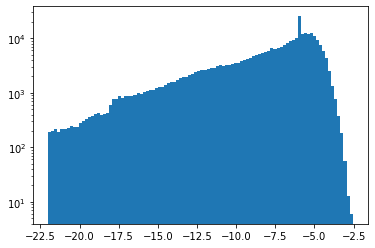

In [16]:
plt.hist(np.log10(mp_data["QR_TAU_out_v2"][mp_data["QR_TAU_out_v2"] > 0]), bins=100)
plt.gca().set_yscale("log")

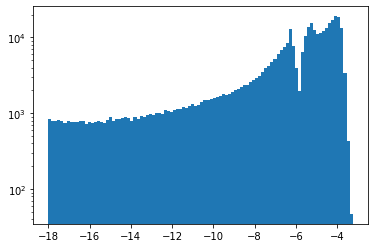

In [17]:
plt.hist(np.log10(mp_data["QC_TAU_out_v2"][mp_data["QC_TAU_out_v2"] > 0]), bins=100)
plt.gca().set_yscale("log")

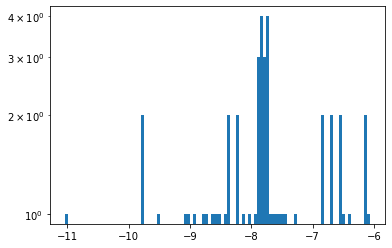

In [18]:
plt.hist(np.log10(-mp_data["QC_TAU_out_v2"][mp_data["QC_TAU_out_v2"] < 0]), bins=100)
plt.gca().set_yscale("log")

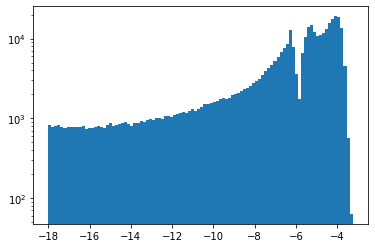

In [19]:
plt.hist(np.log10(mp_data["QC_TAU_in_v2"][mp_data["QC_TAU_in_v2"] > 0]), bins=100)
plt.gca().set_yscale("log")

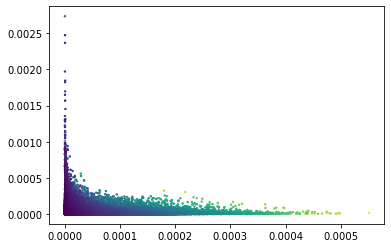

In [20]:
plt.scatter(mp_data["QC_TAU_out_v2"], mp_data["QR_TAU_out_v2"], 2, mp_data["QC_TAU_in_v2"])

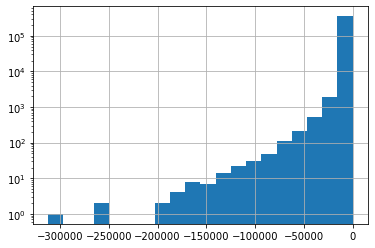

In [34]:
mp_data["nctend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

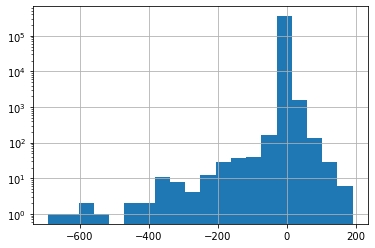

In [35]:
mp_data["nrtend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

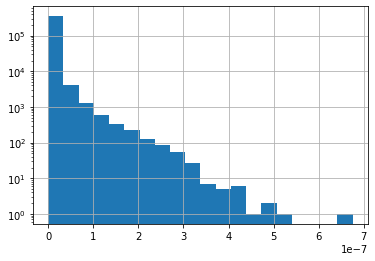

In [36]:
mp_data["qrtend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

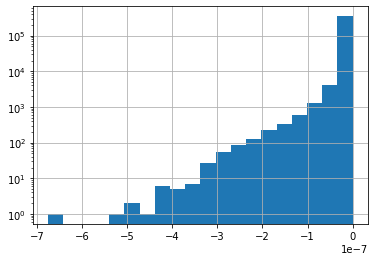

In [37]:
mp_data["qctend_TAU_v2"].hist(bins=20)
plt.gca().set_yscale("log")

In [46]:
np.count_nonzero(mp_data["qctend_TAU_v2"] > 0)

7607

In [51]:
good_indices = (mp_data["qctend_TAU_v2"] <= 0) & (mp_data["qrtend_TAU_v2"] >= 0) & (np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]) == 0)
np.count_nonzero(good_indices)

307064

In [49]:
np.count_nonzero(np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]) == 0)

314674

In [43]:
mp_data["qrtend_TAU_v2"].shape

(356370,)

In [20]:
fig = go.Figure(data=go.Scattergl(x=mp_data["QC_TAU_out_v2"], 
                                  y=mp_data["QR_TAU_out_v2"],
                                  mode="markers",
                                  marker=dict(color=mp_data["QC_TAU_in_v2"],
                                             colorscale="Viridis",
                                             line_width=1)
                                 )
                 )
fig.write_html("mass_scatter.html")

In [18]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=go.Scatter(
    y = np.random.randn(500),
    mode='markers',
    marker=dict(
        size=16,
        color=np.random.randn(500), #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.show()
fig.write_html("test.html")

In [46]:
(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]).min()

-4.656613e-10

In [28]:
np.count_nonzero((mp_data["Q_mass_in"] - mp_data["Q_mass_out"]) == 0) / mp_data.shape[0]

0.8081452944204697

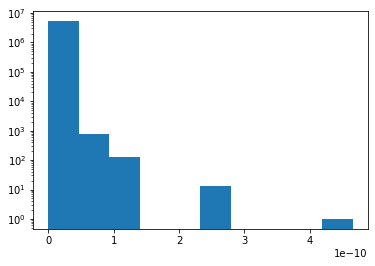

In [25]:
plt.hist(np.abs(mp_data["Q_mass_in"] - mp_data["Q_mass_out"]), bins=10)
plt.gca().set_yscale("log")

In [4]:
def cloud_bins(diameters, lam_c, mu_c, nc):
    return nc * lam_c ** (mu_c + 1) / gamma(mu_c + 1) * (diameters * 1e-2) ** mu_c * np.exp(-lam_c * diameters * 1e-2)

def rain_bins(diameters, lam_r, n0r):
    return n0r * np.exp(-lam_r * diameters * 1e-2)

In [7]:
diams = np.zeros(36)
diams[0] = 1.5625*2.e-4
for i in range(1, diams.size):
    diams[i] = diams[i-1] * 2

In [8]:
diam_means = 0.5 * (diams[1:] + diams[:-1])

In [170]:
diams > 40e-4

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [57]:
mp_data.columns

Index(['lat', 'lev', 'lon', 'P0', 'PS', 'depth', 'row', 'col', 'hyam', 'hybm',
       'pressure', 'temperature', 'RHO_CLUBB_lev', 'RHO_CLUBB_top',
       'RHO_CLUBB_bottom', 'QC_TAU_in', 'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in',
       'lamc', 'lamr', 'lcldm', 'n0r', 'pgam', 'precip_frac', 'qctend_MG2',
       'qctend_TAU', 'nctend_MG2', 'nctend_TAU', 'qrtend_MG2', 'qrtend_TAU',
       'nrtend_MG2', 'nrtend_TAU', 'QC_TAU_out', 'NC_TAU_out', 'QR_TAU_out',
       'NR_TAU_out', 'QC_MG2_out', 'NC_MG2_out', 'QR_MG2_out', 'NR_MG2_out',
       'time', 'frac_mass', 'Q_mass_in', 'mass_diff_TAU', 'mass_diff_MG2',
       'tend_diff_TAU', 'tend_diff_MG2'],
      dtype='object')

Text(0, 0.5, 'Number Concentration')

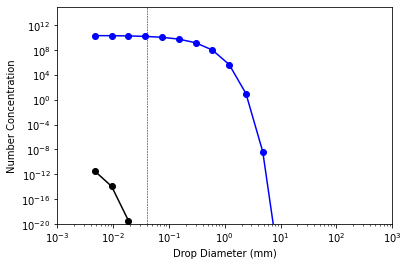

In [195]:
q = 122031
mp_data.loc[q]
plt.plot(diam_means * 10, cloud_bins(diam_means, mp_data.loc[q, "lamc"], mp_data.loc[q, "pgam"], mp_data.loc[q, "NC_TAU_in"] * mp_data.loc[q, "lcldm"]), 'ko-')
plt.plot(diam_means * 10, rain_bins(diam_means, mp_data.loc[q, "lamr"], mp_data.loc[q, "n0r"]), 'bo-')

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.plot(np.ones(10) * 40e-4 * 10, np.linspace(1e-20, 1e15, 10), 'k--', lw=0.5)
plt.ylim(1e-20, 1e15)
plt.xlim(1e-3, 1000)
plt.xlabel("Drop Diameter (mm)")
plt.ylabel("Number Concentration")

Text(0.5, 0, 'Drop Diameter (mm)')

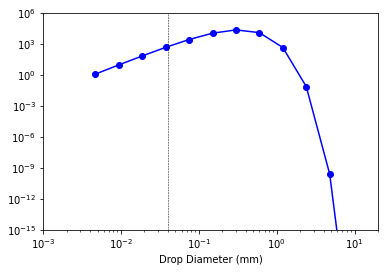

In [196]:
c_nc = cloud_bins(diam_means, mp_data.loc[q, "lamc"], mp_data.loc[q, "pgam"], mp_data.loc[q, "NC_TAU_in"] * mp_data.loc[q, "lcldm"])
c_nr = rain_bins(diam_means, mp_data.loc[q, "lamr"], mp_data.loc[q, "n0r"])
c_mass = 4.0 / 3.0 * np.pi * (diam_means / 100 / 2) ** 3 * 1000 * c_nc * 1000
r_mass = 4.0 / 3.0 * np.pi * (diam_means / 100 / 2) ** 3 * 1000 * c_nr * 1000
plt.plot(diam_means * 10, c_mass, 'ko-')
plt.plot(diam_means * 10, r_mass, 'bo-')
plt.plot(np.ones(10) * 40e-4 * 10, np.linspace(1e-20, 1e15, 10), 'k--', lw=0.5)

plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.ylim(1e-15, 1e6)
plt.xlim(1e-3, 20)
plt.xlabel("Drop Diameter (mm)")


In [166]:
r_mass.max()

0.27496233683925553

In [101]:
np.count_nonzero(mp_data["pgam"] > -100) / mp_data.shape[0]

0.7000978424083298

/glade/work/dgagne/miniconda3/envs/mlmicro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, -2.497598171234131] is not finite

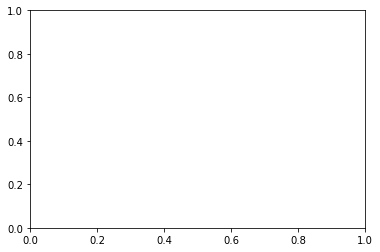

In [205]:
np.log10(mp_data.loc[mp_data["pgam"] < -1, "QR_TAU_in"]).hist()

In [197]:
mp_data.loc[q]

lat                -4.287958e+01
lev                 8.208584e+02
lon                 1.100000e+02
P0                  1.000000e+05
PS                  1.015916e+05
depth               2.400000e+01
row                 5.000000e+01
col                 8.800000e+01
hyam                3.718866e-02
hybm                7.836697e-01
pressure            8.333310e+04
temperature         2.717724e+02
RHO_CLUBB_lev       1.068391e+00
RHO_CLUBB_top       1.044226e+00
RHO_CLUBB_bottom    1.092557e+00
QC_TAU_in           1.175494e-38
NC_TAU_in           1.000000e-12
QR_TAU_in           5.817244e-06
NR_TAU_in           2.422728e+02
lamc                1.500000e+06
lamr                8.974171e+03
lcldm               1.000000e-04
n0r                 2.212028e+10
pgam                2.000000e+00
precip_frac         1.000000e-04
qctend_MG2          0.000000e+00
qctend_TAU          0.000000e+00
nctend_MG2          0.000000e+00
nctend_TAU          0.000000e+00
qrtend_MG2          0.000000e+00
qrtend_TAU

In [194]:
mp_data.loc[(mp_data["pgam"] > 1) & (mp_data["qrtend_TAU"] < 0)]["QC_TAU_in"].idxmin()

122031

<AxesSubplot:>

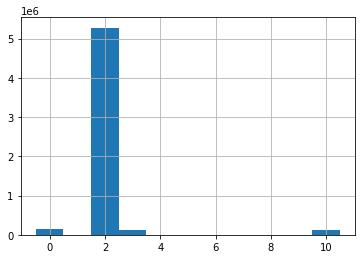

In [106]:
mp_data["pgam"].hist(bins=np.arange(-0.5, 11.5, 1))
#plt.gca().set_yscale("log")

In [183]:
 mp_data["QR_TAU_in"].idxmax()

239527

In [22]:
mp_data.loc[mp_data["tend_diff_TAU"] > 0]

,lat,lev,lon,P0,PS,depth,row,col,hyam,hybm,...,NC_MG2_out,QR_MG2_out,NR_MG2_out,time,frac_mass,Q_mass_in,mass_diff_TAU,mass_diff_MG2,tend_diff_TAU,tend_diff_MG2
5440,-88.115183,957.485480,31.25,100000.0,68667.195312,29,2,25,0.006255,0.951231,...,9740750.0,5.883593e-11,0.898947,0.000000,0.000003,0.000003,0.0,0.000000e+00,3.867864e-25,0.0
5442,-88.115183,957.485480,33.75,100000.0,68518.976562,29,2,27,0.006255,0.951231,...,8702992.0,3.584580e-10,5.476834,0.000000,0.000006,0.000006,0.0,0.000000e+00,2.097941e-24,0.0
5444,-88.115183,957.485480,36.25,100000.0,68371.421875,29,2,29,0.006255,0.951231,...,9087311.0,9.075018e-10,13.865605,0.000000,0.000009,0.000009,0.0,0.000000e+00,1.074769e-24,0.0
5449,-88.115183,957.485480,42.50,100000.0,68013.281250,29,2,34,0.006255,0.951231,...,8552008.0,1.016900e-09,15.537095,0.000000,0.000009,0.000009,0.0,0.000000e+00,3.934396e-25,0.0
5450,-88.115183,957.485480,43.75,100000.0,67944.789062,29,2,35,0.006255,0.951231,...,7424966.0,7.946899e-10,12.141966,0.000000,0.000008,0.000008,0.0,0.000000e+00,3.525568e-24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103710,90.000000,912.644547,350.00,100000.0,101626.414062,27,191,280,0.016407,0.896237,...,5174241.5,2.681763e-08,411.307007,395.833333,0.000032,0.000032,0.0,3.637979e-12,2.263761e-23,0.0
8103712,90.000000,912.644547,352.50,100000.0,101626.414062,27,191,282,0.016407,0.896237,...,5174241.5,2.681763e-08,411.307007,395.833333,0.000032,0.000032,0.0,3.637979e-12,5.519855e-24,0.0
8103713,90.000000,912.644547,353.75,100000.0,101626.414062,27,191,283,0.016407,0.896237,...,5174241.5,2.681763e-08,411.307007,395.833333,0.000032,0.000032,0.0,3.637979e-12,3.716456e-24,0.0
8103714,90.000000,912.644547,355.00,100000.0,101626.414062,27,191,284,0.016407,0.896237,...,5174241.5,2.681763e-08,411.307007,395.833333,0.000032,0.000032,0.0,3.637979e-12,4.751644e-24,0.0


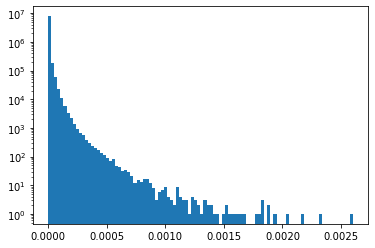

In [35]:
plt.hist(np.abs(mp_data["frac_mass"] - mp_data["Q_mass_in"]), bins=100)
plt.gca().set_yscale("log")

In [34]:
np.count_nonzero(np.abs(mp_data["frac_mass"] - mp_data["Q_mass_in"]) > 0) / mp_data.shape[0]

0.9274353567669809

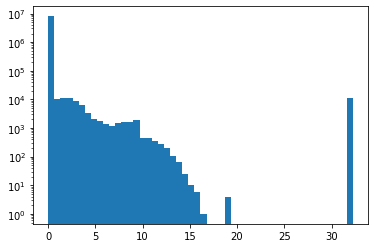

In [89]:
plt.hist(np.abs(mp_data["lcldm_logit"] - mp_data["precip_frac_logit"]), bins=50)
plt.gca().set_yscale('log')

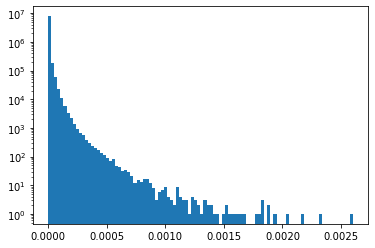

In [40]:
plt.hist(np.abs(mp_data["frac_mass"] - (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"])), bins=100)
plt.gca().set_yscale('log')

In [41]:
np.count_nonzero(np.abs(mp_data["frac_mass"] - (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"]))) / mp_data.shape[0]

0.9416364482095333

In [13]:
mp_data.loc[:, "mass_diff_TAU"] = (mp_data["QC_TAU_out"].values + mp_data["QR_TAU_out"].values) - (mp_data["QC_TAU_in"].values + mp_data["QR_TAU_in"].values)
mp_data.loc[:, "mass_diff_MG2"] = (mp_data["QC_MG2_out"].values + mp_data["QR_MG2_out"].values) - (mp_data["QC_TAU_in"].values + mp_data["QR_TAU_in"].values)
mp_data.loc[:, "tend_diff_TAU"] = (mp_data["qctend_TAU"].values + mp_data["qrtend_TAU"].values)
mp_data.loc[:, "tend_diff_MG2"] = (mp_data["qctend_MG2"].values + mp_data["qrtend_MG2"].values)
ix = (mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_mass_data = mp_data.loc[ix].reset_index()

In [199]:
np.count_nonzero(mp_mass_data["pgam"] < -1) / mp_mass_data.shape[0]

0.39685949375753893

In [200]:
mp_mass_data.loc[(mp_mass_data["pgam"]) & (mp_mass_data["qrtend_TAU"] < )] < -1].iloc[0]

index               0.000000e+00
lat                -9.000000e+01
lev                 3.643466e+00
lon                 0.000000e+00
P0                  1.000000e+05
PS                  6.834913e+04
depth               0.000000e+00
row                 0.000000e+00
col                 0.000000e+00
hyam                3.643466e-03
hybm                0.000000e+00
pressure            3.643466e+02
temperature         1.725399e+02
RHO_CLUBB_lev       7.357718e-03
RHO_CLUBB_top       4.597879e-03
RHO_CLUBB_bottom    1.011756e-02
QC_TAU_in           9.563975e-23
NC_TAU_in           1.000000e-12
QR_TAU_in           6.149233e-23
NR_TAU_in           1.000000e-12
lamc                0.000000e+00
lamr                0.000000e+00
lcldm               1.000000e-04
n0r                 0.000000e+00
pgam               -1.000000e+02
precip_frac         1.000000e-04
qctend_MG2          0.000000e+00
qctend_TAU          0.000000e+00
nctend_MG2          0.000000e+00
nctend_TAU          0.000000e+00
qrtend_MG2

In [11]:
mp_mass_data

,index,lat,lev,lon,P0,PS,depth,row,col,hyam,...,NR_TAU_out,QC_MG2_out,NC_MG2_out,QR_MG2_out,NR_MG2_out,time,mass_diff_TAU,mass_diff_MG2,tend_diff_TAU,tend_diff_MG2
0,0,-90.0,3.643466,0.00,100000.0,68349.132812,0,0,0,0.003643,...,1.000000e-12,9.563975e-23,1.000000e-12,6.149233e-23,1.000000e-12,0.000000,0.0,0.000000e+00,0.0,0.0
1,1,-90.0,3.643466,1.25,100000.0,68349.132812,0,0,1,0.003643,...,1.000000e-12,9.563975e-23,1.000000e-12,6.149233e-23,1.000000e-12,0.000000,0.0,0.000000e+00,0.0,0.0
2,2,-90.0,3.643466,2.50,100000.0,68349.132812,0,0,2,0.003643,...,1.000000e-12,9.563975e-23,1.000000e-12,6.149233e-23,1.000000e-12,0.000000,0.0,0.000000e+00,0.0,0.0
3,3,-90.0,3.643466,3.75,100000.0,68349.132812,0,0,3,0.003643,...,1.000000e-12,9.563975e-23,1.000000e-12,6.149233e-23,1.000000e-12,0.000000,0.0,0.000000e+00,0.0,0.0
4,4,-90.0,3.643466,5.00,100000.0,68349.132812,0,0,4,0.003643,...,1.000000e-12,9.563975e-23,1.000000e-12,6.149233e-23,1.000000e-12,0.000000,0.0,0.000000e+00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273476,8104865,90.0,992.556095,353.75,100000.0,101626.414062,31,191,283,0.000000,...,7.417124e+01,3.153452e-05,4.713692e+06,5.288511e-08,4.860294e+02,395.833333,0.0,0.000000e+00,0.0,0.0
5273477,8104866,90.0,992.556095,355.00,100000.0,101626.414062,31,191,284,0.000000,...,7.417290e+01,3.153754e-05,4.713664e+06,5.289041e-08,4.861309e+02,395.833333,0.0,0.000000e+00,0.0,0.0
5273478,8104867,90.0,992.556095,356.25,100000.0,101626.414062,31,191,285,0.000000,...,7.417296e+01,3.153765e-05,4.713662e+06,5.289060e-08,4.861345e+02,395.833333,0.0,0.000000e+00,0.0,0.0
5273479,8104868,90.0,992.556095,357.50,100000.0,101626.414062,31,191,286,0.000000,...,7.417297e+01,3.153768e-05,4.713663e+06,5.289066e-08,4.861356e+02,395.833333,0.0,0.000000e+00,0.0,0.0


In [12]:
mp_mass_data.loc[:, "Q_mass_out"] = mp_mass_data[["QC_TAU_out", "QR_TAU_out"]].sum(axis=1)
mp_mass_data.loc[:, "Q_mass_in"] = mp_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)
mp_mass_data.loc[:, "QR_prop_out"] = mp_mass_data["QR_TAU_out"] / mp_mass_data["Q_mass_in"] 
mp_mass_data.loc[:, "QC_prop_out"] = mp_mass_data["QC_TAU_out"] / mp_mass_data["Q_mass_in"] 
mp_mass_data.loc[:, "QR_prop_in"] = mp_mass_data["QR_TAU_in"] / mp_mass_data["Q_mass_in"] 
mp_mass_data.loc[:, "QC_prop_in"] = mp_mass_data["QC_TAU_in"] / mp_mass_data["Q_mass_in"] 

In [7]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & 
                 np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

0.6506558402540694

In [8]:
np.count_nonzero((mp_data["mass_diff_TAU"] == 0)) / mp_data.shape[0]

0.9100602477276009

In [9]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0)) / mp_data.shape[0]

0.8105487194736004

In [10]:
np.count_nonzero(np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

0.9130044035252879

Test mass conservation (mass diff should be 0). A significant proportion of grid cells have mass conserved

In [19]:
np.max(np.abs(mp_mass_data["QR_prop_out"] + mp_mass_data["QC_prop_out"]))

1.0000001

(array([1450464.,  208228.,  129455.,   98413.,   91823.,  118884.,
         997932.,  133223.,   78022.,   71076.,   68974.,   78131.,
          85234.,   85627.,   56481.,   46000.,   39308.,   35462.,
          28084.,   26001.,   19922.,   17790.,   17397.,   16972.,
          16377.,   16034.,   15852.,   15304.,   14914.,   14845.,
          14641.,   14497.,   14418.,   13945.,   14087.,   14240.,
          14251.,   14183.,   14400.,   14542.,   14947.,   15547.,
          16281.,   17378.,   18861.,   21440.,   25061.,   32075.,
          49328.,  827130.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32),
 <BarContainer object of 50 artists>)

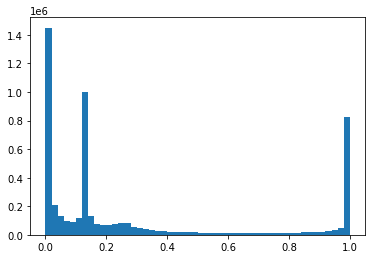

In [13]:
plt.hist(mp_mass_data["QR_prop_out"], bins=50)

In [13]:
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "precip_frac", "lcldm"]
output_cols = ["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]
scale_in = StandardScaler()
in_data_transformed = pd.DataFrame(0, columns=input_cols, index=mp_mass_data.index)
for input_col in input_cols:
    if input_col in ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in"]:
        in_data_transformed.loc[:, input_col] = np.log10(np.maximum(mp_mass_data[input_col].values, 1e-38))
    else:
        in_data_transformed.loc[:, input_col] = mp_mass_data[input_col]
in_data = scale_in.fit_transform(in_data_transformed)
out_data = mp_mass_data.loc[:, output_cols]
for col in output_cols:
    out_data.loc[:, col] = np.log10(np.maximum(out_data.loc[:, col], 1e-38))

In [14]:
out_data.min()

QC_TAU_out   -37.929779
QR_TAU_out   -38.000000
NC_TAU_out   -12.000000
NR_TAU_out   -12.000000
dtype: float32

In [91]:
from tensorflow.experimental.numpy import log10 as tflog10
def mass_loss(y_true_log, y_pred_log, scale_factor=2):
    
    y_true = 10 ** y_true_log
    y_pred = 10 ** y_pred_log
    mse_loss = tf.reduce_mean((y_true_log - y_pred_log) ** 2, axis=0)
    mass_in_true_l = tflog10(tf.reduce_sum(y_true[:, 0:2], axis=1))
    mass_out_pred_l = tflog10(tf.reduce_sum(y_pred[:, 2:4], axis=1))
    mass_in_pred_l = tflog10(tf.reduce_sum(y_pred[:, 0:2], axis=1))

    mass_diff_loss = tf.reduce_mean(tf.abs(mass_in_true_l - mass_out_pred_l))
    mass_diff_loss += tf.reduce_mean(tf.abs(mass_in_true_l - mass_in_pred_l))
    loss = tf.reduce_sum(mse_loss) + scale_factor * mass_diff_loss
    loss = tf.reduce_sum(mse_loss)
    return loss

In [15]:
multi_dnn = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=128, activation="relu", output_activation="linear",
                               lr=1e-4, batch_size=512, loss="huber", verbose=1, l2_weight=0, epochs=30)
multi_dnn.fit(in_data, out_data)

2021-08-04 11:13:07.974233: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-04 11:13:07.975602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-04 11:13:08.350873: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-04 11:13:08.350926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc37): /proc/driver/nvidia/version does not exist
2021-08-04 11:13:08.351579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-04 11:13:08.35

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_01 (Dense)             (None, 4)                 516       
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________


2021-08-04 11:13:08.601065: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-04 11:13:08.601502: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz


Epoch 1/30
10300/10300 [==============================] - 10s 903us/step - loss: 4.2146
Epoch 2/30
10300/10300 [==============================] - 8s 801us/step - loss: 0.0570
Epoch 3/30
10300/10300 [==============================] - 9s 911us/step - loss: 0.0347
Epoch 4/30
10300/10300 [==============================] - 9s 842us/step - loss: 0.0281
Epoch 5/30
10300/10300 [==============================] - 9s 857us/step - loss: 0.0254
Epoch 6/30
10300/10300 [==============================] - 9s 890us/step - loss: 0.0237
Epoch 7/30
10300/10300 [==============================] - 9s 840us/step - loss: 0.0227
Epoch 8/30
10300/10300 [==============================] - 9s 885us/step - loss: 0.0217
Epoch 9/30
10300/10300 [==============================] - 9s 830us/step - loss: 0.0209
Epoch 10/30
10300/10300 [==============================] - 9s 898us/step - loss: 0.0203
Epoch 11/30
10300/10300 [==============================] - 9s 905us/step - loss: 0.0196
Epoch 12/30
10300/10300 [===============

{'loss': [1.6555263996124268,
  0.048750441521406174,
  0.03257323428988457,
  0.02722080424427986,
  0.024909477680921555,
  0.023483334109187126,
  0.022431643679738045,
  0.021550018340349197,
  0.020774826407432556,
  0.020088540390133858,
  0.019436096772551537,
  0.01882542483508587,
  0.01826416328549385,
  0.01775074563920498,
  0.0172840878367424,
  0.016868792474269867,
  0.016501719132065773,
  0.016166817396879196,
  0.015857568010687828,
  0.015563739463686943,
  0.015285405330359936,
  0.015024595893919468,
  0.014778814278542995,
  0.014548078179359436,
  0.014314181171357632,
  0.014078731648623943,
  0.013847644440829754,
  0.013640806078910828,
  0.013448788784444332,
  0.01326681673526764]}

In [23]:
len(mp_files)

701

In [21]:
mp_test_data = pd.concat([pd.read_parquet(mp_files[x]) for x in range(500, 700, 20)], ignore_index=True)
#mp_test_data.loc[:, "precip_frac_logit"] = logit(mp_test_data["precip_frac"].values)
#mp_test_data.loc[:, "lcldm_logit"] = logit(mp_test_data["lcldm"].values)
dt = 60 * 30 #minutes
mp_test_data["tend_diff_TAU"] = (mp_test_data["qctend_TAU"] + mp_test_data["qrtend_TAU"])
mp_test_data["mass_diff_TAU"] = (mp_test_data["QC_TAU_out"] + mp_test_data["QR_TAU_out"]) - (mp_test_data["QC_TAU_in"] + mp_test_data["QR_TAU_in"])

ixt = (mp_test_data["tend_diff_TAU"] == 0) & (mp_test_data["mass_diff_TAU"] == 0) & \
    np.all(mp_test_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_test_mass_data = mp_test_data.loc[ixt].reset_index()
mp_test_mass_data.loc[:, "Q_mass_in"] = mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)
mp_test_mass_data.loc[:, "QR_prop_out"] = mp_test_mass_data["QR_TAU_out"] / mp_test_mass_data["Q_mass_in"] 
mp_test_mass_data.loc[:, "QC_prop_out"] = mp_test_mass_data["QC_TAU_out"] / mp_test_mass_data["Q_mass_in"]
mp_test_mass_data.loc[:, "QR_prop_in"] = mp_test_mass_data["QR_TAU_in"] / mp_test_mass_data["Q_mass_in"] 
mp_test_mass_data.loc[:, "QC_prop_in"] = mp_test_mass_data["QC_TAU_in"] / mp_test_mass_data["Q_mass_in"] 
in_data_transformed = pd.DataFrame(0, columns=input_cols, index=mp_test_mass_data.index)
for input_col in input_cols:
    if input_col in ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in"]:
        in_data_transformed.loc[:, input_col] = np.log10(np.maximum(mp_test_mass_data[input_col].values, 1e-38))
    else:
        in_data_transformed.loc[:, input_col] = mp_test_mass_data[input_col]
in_test_data = scale_in.transform(in_data_transformed)
out_test_data = mp_test_mass_data.loc[:, output_cols]
for col in output_cols:
    out_test_data.loc[:, col] = np.log10(np.maximum(out_test_data.loc[:, col], 1e-38))

In [52]:
mp_test_mass_data.loc[:, output_cols].shape

(2642804, 4)

In [23]:

mod_preds = multi_dnn.model.predict(in_test_data, batch_size=8192)

In [24]:
from sklearn.metrics import r2_score
for i in range(4):
    
    print(output_cols[i], r2_score(out_test_data.iloc[:, i], mod_preds[:, i]))

QC_TAU_out 0.9999800188972386
QR_TAU_out 0.9993145473566181
NC_TAU_out 0.9998880507178306
NR_TAU_out 0.999032870692466


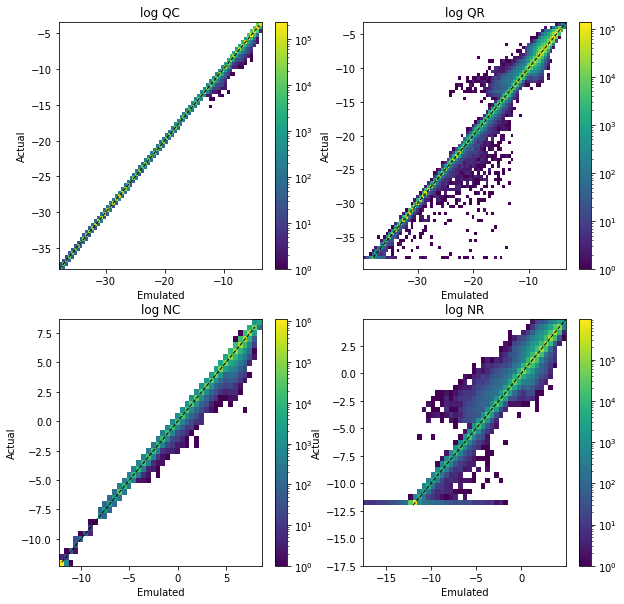

In [28]:
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.hist2d(mod_preds[:, i], out_test_data.loc[:,output_cols[i]], cmin=1, norm=LogNorm(), bins=np.arange(mod_preds[:, i].min(), mod_preds[:, i].max(), 0.5))
    plt.xlabel("Emulated")
    plt.ylabel("Actual")
    plt.title("log " + output_cols[i].split("_")[0])
    diag = np.arange(out_test_data.iloc[:, i].min(), out_test_data.iloc[:, i].max(), 1)
    plt.plot(diag, diag, 'k--', lw=1)
    plt.colorbar()
plt.savefig("mass_hist_out.png", dpi=200, bbox_inches="tight")

In [124]:
in_data[::100].shape

(52735, 6)

In [125]:
multi_dnn._estimator_type = "regressor"
multi_dnn.model_ = multi_dnn.model
pd_out = partial_dependence(multi_dnn, pd.DataFrame(in_data[::100], columns=input_cols), features=input_cols[0], grid_resolution=10)

/glade/work/dgagne/miniconda3/envs/mlmicro/lib/python3.8/site-packages/sklearn/inspection/_partial_dependence.py:505: FutureWarning: A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.
  warnings.warn(


In [129]:
pd_out[1]

[array([-1.46745162, -1.17744087, -0.88743012, -0.59741936, -0.30740861,
        -0.01739786,  0.27261289,  0.56262364,  0.85263439,  1.14264514])]

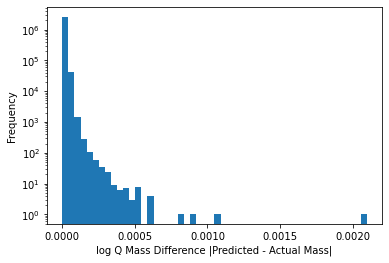

In [32]:
pred_mass = np.sum(10 ** mod_preds[:, 0:1], axis=1)
plt.hist(np.abs(mp_test_mass_data["Q_mass_in"] - pred_mass), bins=50)
plt.xlabel("log Q Mass Difference |Predicted - Actual Mass|")
plt.ylabel("Frequency")
plt.savefig("mass_diff_hist.png", dpi=200, bbox_inches="tight")
plt.gca().set_yscale("log")

In [38]:

input_cols_q = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "precip_frac", "lcldm"]
output_cols_q = ["QC_TAU_out", "QR_TAU_out"]
in_data_transformed_q = pd.DataFrame(0, columns=input_cols_q, index=mp_mass_data.index)
for input_col in input_cols_q:
    if input_col in ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "Q_mass_in"]:
        in_data_transformed_q.loc[:, input_col] = np.log10(np.maximum(mp_mass_data[input_col].values, 1e-38))
    else:
        in_data_transformed_q.loc[:, input_col] = mp_mass_data[input_col]
scale_in_q = StandardScaler()
in_data_q = scale_in_q.fit_transform(in_data_transformed_q)
out_data_q = np.log10(mp_mass_data[output_cols_q])

In [ ]:
mp_mass_data["QC_prop_out"]

I am attempting to fit a neural network that predicts the partitioning of QR and QC simultanenously. I fit a neural network with a softmax activation function to do so. It appears to be having trouble fitting both values very well and has lots of artifacts throughout the histogram.

I am fitting an ANN to predict the QC mass partition with a sigmoid activation function.

In [68]:
dnn_qc = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=128, activation="relu", output_activation="linear", batch_size=128, 
                         epochs=30, verbose=1, loss="mse", lr=1e-4, l2_weight=0)
dnn_qc_hist = dnn_qc.fit(in_data_q, out_data_q.iloc[:, 0].values)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_01 (Dense)             (None, 1)                 129       
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
41200/41200 [==============================] - 22s 530us/step - loss: 43.6390
Epoch 2/30
41200/41200 [==============================] - 22s 542us/step - loss: 0.0024
Epoch 3/30
41200/41200 [==============================] - 22s 527us/step - loss: 0.0018
Epoch 4/30
41200/41200 [==============================] - 22s 529us/step - loss: 0.0016
Epoch 5/30
41200/41200 [==========

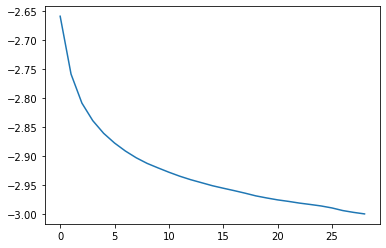

In [69]:
plt.plot(np.log10(dnn_qc_hist["loss"][1:]))

In [70]:
in_test_data_q = scale_in_q.transform(np.log10(np.maximum(mp_test_mass_data[input_cols_q], 1e-38)))

out_pred_qc = dnn_qc.model.predict(in_test_data_q, batch_size=8192)[:, 0]
out_pred_qc_total = np.zeros((out_pred_qc.shape[0], 2)) 
out_pred_qc_total[:, 0] = 10 ** out_pred_qc
out_pred_qc_total[:, 1] = mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values - 10 ** out_pred_qc
#out_pred_qc_total[:, 0] = out_pred_qc * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values
#out_pred_qc_total[:, 1] = (1 - out_pred_qc) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values


(array([[2.89000e+02, 1.92000e+02, 5.48000e+02, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., 4.75520e+04,
                 nan,         nan],
        [        nan,         nan,         nan, ..., 4.30260e+04,
         8.00000e+01,         nan],
        [        nan,         nan,         nan, ..., 1.67641e+05,
         3.31999e+05, 1.15519e+05]]),
 array([-247.29257202, -242.41270939, -237.53284677, -232.65298414,
        -227.77312151, -222.89325888, -218.01339625, -213.13353363,
        -208.253671  , -203.37380837, -198.49394574, -193.61408311,
        -188.73422049, -183.85435786, -178.97449523, -174.0946326 ,
        -169.21476997, -164.33490735, -159.45504472, -154.57518209,
        -149.69531946, -144.81545

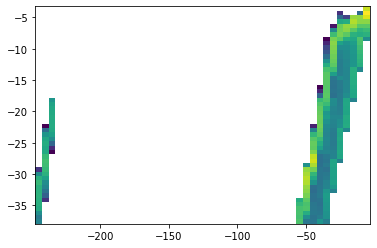

In [71]:
plt.hist2d(out_pred_qc, out_test_data["QC_TAU_out"], bins=50, cmin=1, norm=LogNorm())

In [60]:
out_pred_qc.min()

-76.108864

(array([ 955034.,   83014.,   71616.,   71588.,   76949.,   88458.,
         174855.,  374447., 1399137., 1978383.]),
 array([8.122813e-31, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

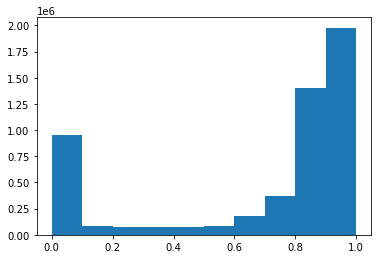

In [205]:
plt.hist(out_data_q.iloc[:,0])

In [58]:
out_pred_qc_total.min(axis=0)

array([ 0.        , -0.00012991])

/glade/scratch/dgagne/ipykernel_8689/1985330140.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist2d(np.log10(out_pred_qc_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
/glade/scratch/dgagne/ipykernel_8689/1985330140.py:6: RuntimeWarning: divide by zero encountered in log10
  print(np.corrcoef(np.log10(np.maximum(out_pred_qc_total[ix, 0], 1-38)), np.log10(np.maximum(mp_test_mass_data.loc[ix, "QC_TAU_out"], 1e-38))) **2)
/glade/work/dgagne/miniconda3/envs/mlmicro/lib/python3.8/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


[[nan nan]
 [nan  1.]]


/glade/scratch/dgagne/ipykernel_8689/1985330140.py:15: RuntimeWarning: invalid value encountered in log10
  plt.hist2d(np.log10(out_pred_qc_total[ix, 1]), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())


[[1.         0.94540765]
 [0.94540765 1.        ]]


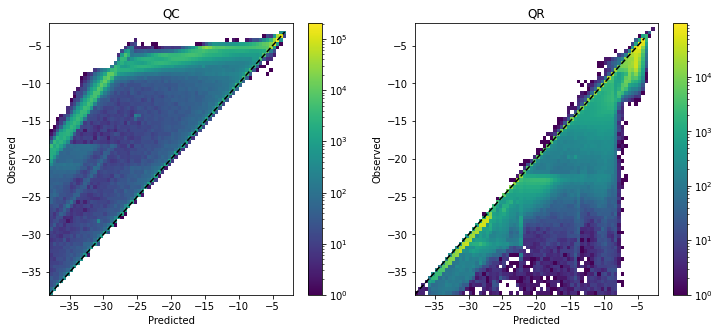

In [72]:
ix = mp_test_mass_data["QC_TAU_out"] > 0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(np.log10(out_pred_qc_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
plt.plot(np.arange(-38, -3, 0.2), np.arange(-38, -3, 0.2), 'k--')
print(np.corrcoef(np.log10(np.maximum(out_pred_qc_total[ix, 0], 1-38)), np.log10(np.maximum(mp_test_mass_data.loc[ix, "QC_TAU_out"], 1e-38))) **2)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QC")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.subplot(1, 2, 2)
ix = mp_test_mass_data["QR_TAU_out"] > 0
plt.hist2d(np.log10(out_pred_qc_total[ix, 1]), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
print(np.corrcoef(np.log10(np.maximum(out_pred_qc_total[ix, 1], 1e-38)), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"])) **2)


plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QR")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.savefig("qc_qr_hist.png", dpi=200, bbox_inches="tight")


In [73]:
dnn_qc._estimator_type = "regressor"
dnn_qc.model_ = dnn_qc.model
pd_out = {}
for input_col in input_cols_q:
    pd_out[input_col] = partial_dependence(dnn_qc, pd.DataFrame(in_data_q[::100], columns=input_cols_q), features=input_col, grid_resolution=20, kind="average")

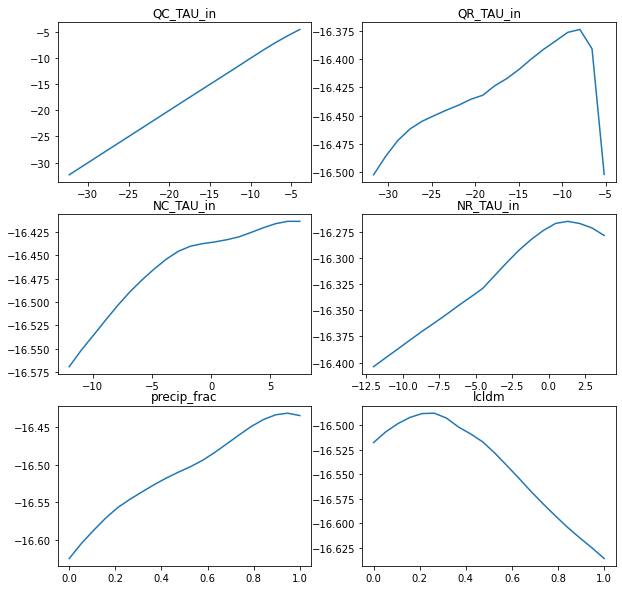

In [74]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, input_col in enumerate(input_cols_q):
    axes.ravel()[i].plot(pd_out[input_col]["values"][0] * scale_in_q.scale_[i] + scale_in_q.mean_[i], pd_out[input_col]["average"][0])
    axes.ravel()[i].set_title(input_col)

In [151]:
scale_in_q.mean_

array([-16.35754835, -16.56178859,  -3.3441548 ,  -4.62959271,
       -28.62425016, -28.65046919])

In [144]:
pd_out[input_col]

{'average': array([[-10.182941, -10.152616, -10.116498, -10.074871, -10.02803 ,
          -9.976268,  -9.91984 ,  -9.858986,  -9.793897,  -9.724737]],
       dtype=float32),
 'values': [array([-0.56370548, -0.30001196, -0.03631843,  0.2273751 ,  0.49106862,
          0.75476215,  1.01845568,  1.28214921,  1.54584273,  1.80953626])]}

In [170]:
dnn_qr = DenseNeuralNetwork(hidden_layers=2, hidden_neurons=128, activation="relu", output_activation="sigmoid", batch_size=256, 
                         epochs=30, verbose=1, loss="huber", lr=1e-4, l2_weight=0)
dnn_qr_hist = dnn_qr.fit(in_data_q, out_data_q.iloc[:, 1])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 128)               896       
_________________________________________________________________
dense_01 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_02 (Dense)             (None, 1)                 129       
Total params: 17,537
Trainable params: 17,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20600/20600 [==============================] - 25s 1ms/step - loss: 0.0071
Epoch 2/30
20600/20600 [==============================] - 25s 1ms/step - loss: 3.3702e-04
Epoch 3/30
20600/20600 [==============================] - 25s 1ms/step - los

In [171]:
in_test_data_q = scale_in_q.transform(np.log10(np.maximum(mp_test_mass_data[input_cols_q], 1e-38)))
out_pred_qr = dnn_qr.model.predict(in_test_data_q, batch_size=8192)[:, 0]
out_pred_qr_total = np.zeros((out_pred_qr.shape[0], 2)) 
out_pred_qr_total[:, 0] = (1 - out_pred_qr) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values
out_pred_qr_total[:, 1] = (out_pred_qr) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1).values

1.51531315e-24

/glade/scratch/dgagne/ipykernel_209350/1586418118.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.hist2d(np.log10(out_pred_qr_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
/glade/scratch/dgagne/ipykernel_209350/1586418118.py:6: RuntimeWarning: divide by zero encountered in log10
  print(np.corrcoef(np.log10(out_pred_qr_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"])) **2)
/glade/work/dgagne/miniconda3/envs/mlmicro/lib/python3.8/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


[[nan nan]
 [nan  1.]]
[[1.         0.99207623]
 [0.99207623 1.        ]]


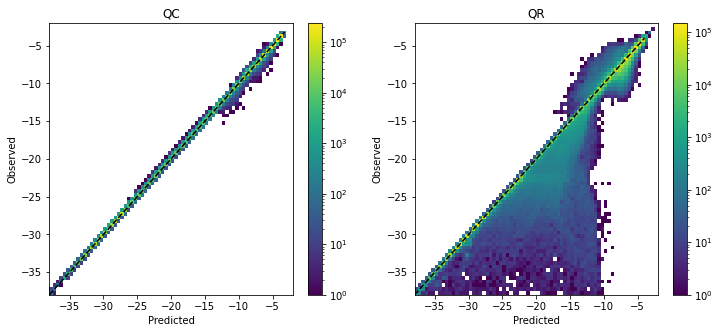

In [172]:
ix = mp_test_mass_data["QC_TAU_out"] > 0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(np.log10(out_pred_qr_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
plt.plot(np.arange(-38, -3, 0.2), np.arange(-38, -3, 0.2), 'k--')
print(np.corrcoef(np.log10(out_pred_qr_total[ix, 0]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"])) **2)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QC")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.subplot(1, 2, 2)
ix = mp_test_mass_data["QR_TAU_out"] > 0
plt.hist2d(np.log10(out_pred_qr_total[ix, 1]), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.5), norm=LogNorm())
print(np.corrcoef(np.log10(np.maximum(out_pred_qr_total[ix, 1], 1e-38)), np.log10(mp_test_mass_data.loc[ix, "QR_TAU_out"])) **2)


plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QR")
plt.xlim(-38, -2)
plt.ylim(-38, -2)
plt.colorbar()
plt.savefig("qr_qc_hist.png", dpi=200, bbox_inches="tight")

In [212]:
out_pred_q_total[ix, 1].max()

0.0020960941910743713

In [140]:
dnn_nr = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=64, activation="tanh", output_activation="linear", batch_size=256, epochs=40, 
                            l2_weight=0, verbose=1)
dnn_nr.fit(in_data, np.log10(mp_mass_data["NR_TAU_out"]))

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_01 (Dense)             (None, 1)                 101       
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
20600/20600 [==============================] - 10s 472us/step - loss: 2.7958
Epoch 2/40
20600/20600 [==============================] - 10s 472us/step - loss: 0.1609
Epoch 3/40
20600/20600 [==============================] - 10s 474us/step - loss: 0.1313
Epoch 4/40
20600/20600 [==============================] - 10s 472us/step - loss: 0.1148
Epoch 5/40
20600/20600 [===============

{'loss': [0.7180818319320679,
  0.15104366838932037,
  0.126512810587883,
  0.11311338096857071,
  0.10539574176073074,
  0.09973710030317307,
  0.09485384821891785,
  0.09099218249320984,
  0.08779978007078171,
  0.0850488543510437,
  0.08277875185012817,
  0.08081736415624619,
  0.07911494374275208,
  0.07754027098417282,
  0.07607919722795486,
  0.07474366575479507,
  0.0734889805316925,
  0.07214546948671341,
  0.07101195305585861,
  0.06977994740009308,
  0.06871077418327332,
  0.06766107678413391,
  0.06646815687417984,
  0.06529919058084488,
  0.06414420157670975,
  0.06297782063484192,
  0.06193380430340767,
  0.060999639332294464,
  0.06004547327756882,
  0.059301022440195084,
  0.05848964676260948,
  0.057822179049253464,
  0.05715567618608475,
  0.05652051046490669,
  0.05587080866098404,
  0.05543198809027672,
  0.054805126041173935,
  0.05431303381919861,
  0.05380377545952797,
  0.05334550887346268]}

In [141]:
out_pred_nr_mix = dnn_nr.predict(in_test_data)

Text(0.5, 1.0, 'NR')

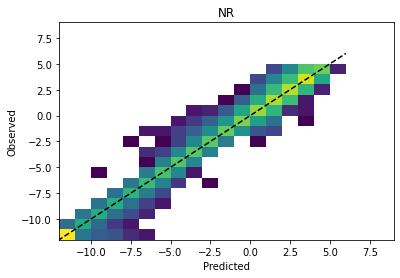

In [142]:
plt.hist2d(out_pred_nr_mix, np.log10(mp_test_mass_data.loc[ix, "NR_TAU_out"]), cmin=1, bins=np.arange(-12, 10), norm=LogNorm())
plt.plot(np.arange(-15, 7), np.arange(-15, 7), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("NR")

In [110]:
ix = mp_test_mass_data[output_col] > 0
plt.hist2d(np.log10(out_pred_qr_total[ix]), np.log10(mp_test_mass_data.loc[ix, output_col]), cmin=1, bins=np.arange(-38, -2), norm=LogNorm())
plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')

0         3.587259e-23
1         2.818454e-23
2         1.609617e-20
3         1.870836e-20
4         3.559898e-20
              ...     
411512    9.715268e-07
411513    9.715268e-07
411514    9.715175e-07
411515    9.715134e-07
411516    9.715134e-07
Name: QR_TAU_out, Length: 264443, dtype: float32

# Experiments to run
1. Train neural net on qc/total mass vs qr / total mass and see how that affects the resulting error scores for qc and qr.
2. Training multi-output model vs. single output models for qc/qr and nc and nr.
3. Perform random search on NN architectures and calculate partial dependence plots on NN hyperparameters.
4. Update Fortran code to support new neural network models.